In [40]:
from datasets import load_dataset
import numpy as np
from torchvision.transforms import (
    ToTensor,
    Compose,
)
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np

dataset = load_dataset("davanstrien/wikiart-resized")


KeyboardInterrupt



In [ ]:
ds_art = dataset['train'].filter(lambda x: x['image'] and x['genre'] == 4)
ds_art[0]['image']

In [146]:
transforms_tv = Compose(
        [
            ToTensor(),
        ]
    )

def transforms(examples):
    examples["pixel_values"] = [np.array(image.convert("RGB").resize((28,28)))/255.
      for image in examples["image"]]
    return examples
ds_art_tr = ds_art.map(transforms, remove_columns=["image"], batched=True)

Map:   0%|          | 0/10950 [00:00<?, ? examples/s]

In [150]:
splits = ds_art_tr.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [90]:
tf.config.list_physical_devices('GPU')

(False, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

Epoch 1/100
tf.Tensor(29782.98, shape=(), dtype=float32)
Epoch 2/100
tf.Tensor(29774.037, shape=(), dtype=float32)
Epoch 3/100
tf.Tensor(29780.791, shape=(), dtype=float32)
Epoch 4/100
tf.Tensor(29796.654, shape=(), dtype=float32)
Epoch 5/100
tf.Tensor(29781.418, shape=(), dtype=float32)
Epoch 6/100
tf.Tensor(29757.764, shape=(), dtype=float32)
Epoch 7/100
tf.Tensor(29760.746, shape=(), dtype=float32)
Epoch 8/100
tf.Tensor(29761.068, shape=(), dtype=float32)
Epoch 9/100
tf.Tensor(29751.469, shape=(), dtype=float32)
Epoch 10/100
tf.Tensor(29745.705, shape=(), dtype=float32)
Epoch 11/100
tf.Tensor(29748.105, shape=(), dtype=float32)
Epoch 12/100
tf.Tensor(29747.732, shape=(), dtype=float32)
Epoch 13/100
tf.Tensor(29746.031, shape=(), dtype=float32)
Epoch 14/100
tf.Tensor(29748.012, shape=(), dtype=float32)
Epoch 15/100
tf.Tensor(29746.941, shape=(), dtype=float32)
Epoch 16/100
tf.Tensor(29768.092, shape=(), dtype=float32)
Epoch 17/100
tf.Tensor(29756.709, shape=(), dtype=float32)
Epoch 1

ValueError: cannot reshape array of size 2352 into shape (28,28)

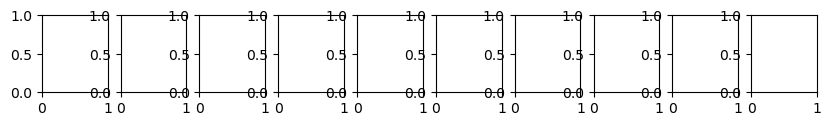

In [196]:
# Define the VAE's encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.dense3 = layers.Dense(128, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the VAE's decoder
class Decoder(Model):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.dense3 = layers.Dense(512, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        output = self.dense_output(x)
        return output

# Define the VAE
class VAE(Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=(tf.shape(inputs)[0], self.latent_dim))
        z = mean + tf.exp(log_var * 0.5) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Define the VAE loss function
def vae_loss(inputs, reconstructed, mean, log_var):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstructed)) * 50000
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)



In [ ]:
# Instantiate and compile the VAE
latent_dim = 64
encoder = Encoder(latent_dim)
decoder = Decoder(3*28*28)
vae = VAE(encoder, decoder, latent_dim)
optimizer = tf.keras.optimizers.Adam(lr=0.001)

# Train the VAE
epochs = 200
batch_size = 100

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i in range(0, len(train_ds), batch_size):
        x_batch = np.array(train_ds[i:i+batch_size]['pixel_values']).reshape((-1, 3*28*28)) 
        with tf.GradientTape() as tape:
            reconstructed, mean, log_var = vae(x_batch)
            loss = vae_loss(x_batch, reconstructed, mean, log_var)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    print(loss)

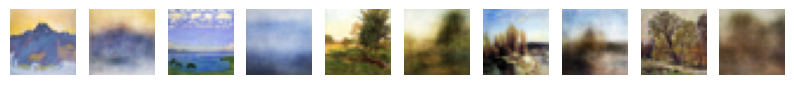

In [198]:
n_samples = 5

fig, axes = plt.subplots(1, 2*n_samples, figsize=(2*n_samples, 1))
for i in range(n_samples):
    a = np.array(train_ds[i+10]['pixel_values']).reshape((-1, 3*28*28))
    axes[2*i].imshow(train_ds[i+10]['pixel_values'])
    axes[2*i].axis('off')
    axes[2*i+1].imshow(np.array(vae(a)[0]).reshape((28,28,3)))
    axes[2*i+1].axis('off')

